# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [19]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# based on code discussed in lectures

import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

# percentage of training set to use as validation
valid_size = 0.2
# define dataloader parameters
batch_size  = 50
num_workers = 0

# define training and test data directories
data_dir  = '/data/landmark_images/'
train_dir = os.path.join(data_dir, 'train') 
test_dir  = os.path.join(data_dir, 'test') 

# load and transform data using ImageFolder
data_transform = transforms.Compose([transforms.Resize(32),
                                     transforms.CenterCrop(32),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data  = datasets.ImageFolder(test_dir, transform=data_transform)

# split indices in two groups that will be used for training  and validation
train_data_len = len(train_data)
train_data_indices = list(range(train_data_len)) # seems we cant use enumerate here, at least i :-/
np.random.shuffle(train_data_indices)
valid_indices,train_indices = np.split(train_data_indices, [int(train_data_len*valid_size)])

## print out some data stats
print('Num training images: ',   len(train_indices))
print('Num validation images: ', len(valid_indices))
print('Num test images: ',       len(test_data))

# use samplers for training and validation batches
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size=batch_size, shuffle=True,          num_workers=num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


Num training images:  3997
Num validation images:  999
Num test images:  1250


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

As you can see the code is strongly inspired by the lectures. However I tryed to reinvent the indicies splitting but I did not turn out better then the solution provieded.

The images provided are landscapes. Most of them are even taken in landscape mode of the camara.
I dont see a point in rotating landscape images. 
So I actually just resized and cropped them to 32 pixles. The provided Images are actually way larger than the CIFAR-10 ones from the lecture, but I decided to start with the network from the lectures and check the results first.

I also normalized the images, this has to be considered for printing the images and the later tests.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

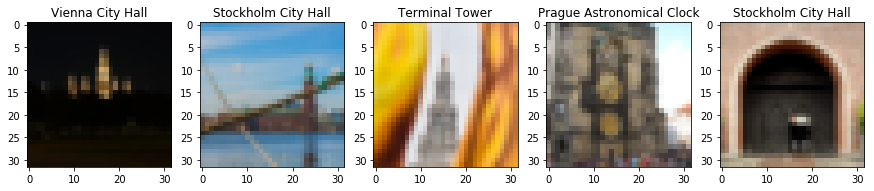

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
    
## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

# based on code discussed in lectures

# list of class names by index, i.e. a name can be accessed like class_names[0]
classes = [item[3:].replace("_", " ") for item in train_data.classes]

# access images and convert to numpy for display
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() 

# plot the images with labels
fig = plt.figure()
fig.set_size_inches(15, 15)
for i in np.arange(5):
    ax = fig.add_subplot(1, 5, i+1)
    plt.imshow(np.transpose(images[i]/2+0.5, (1, 2, 0)))  # unnormalize + convert from Tensor image
    ax.set_title(classes[labels[i]])


### Initialize use_cuda variable

In [3]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [4]:
import torch.optim as optim
import torch.nn as nn # moved below block, cause i need it for loss function! and itss called nn here and not F
import torch.nn.functional as F

# decided to use:
# loss function: CrossEntropyLoss
# Optimicer: SGD

## TODO: select loss function

# specify loss function (categorical cross-entropy)
criterion_scratch = nn.CrossEntropyLoss() 

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    
    # specify optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    return optimizer

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [5]:
# import torch.nn as nn # moved to the above block, cause i need it for loss function!

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN

        # based on code discussed in lectures

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # cl 1 sees 32x32x3 image tensor
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # cl 2 sees 16x16x16 tensor
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # cl 3 sees 8x8x32 tensor
        self.pool = nn.MaxPool2d(2, 2)               # max pooling layer for the downsmapling 32 -> 16 -> 8       
        self.fc1 = nn.Linear(64 * 4 * 4, 500)        # ll 1 computes class scores 64 * 4 * 4 -> 500
        self.fc2 = nn.Linear(500, 50)                # ll 2 computes class scores 500 -> 50
        self.dropout = nn.Dropout(0.25)              # dl with factor p=0.25

    def forward(self, x):
        
        ## Define forward behavior

        # based on code discussed in lectures
        
        x = self.pool(F.relu(self.conv1(x)))         # add sequence of convolutional, relu and max pooling layers
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))        
        x = x.view(-1, 64 * 4 * 4)                   # flatten image input        
        x = self.dropout(x)                          # add dropout layer        
        x = F.relu(self.fc1(x))                      # add hidden fc layer, with relu activation function        
        x = self.dropout(x)                          # add dropout layer        
        x = self.fc2(x)                              # add fc layer
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

As a starting point I decided to use the network from the lectures and it turned out good enough.

To better understand the network I followed the provided guide: https://cs231n.github.io/convolutional-networks/#layers

The most common form of a ConvNet is:
* INPUT -> [[CONV -> RELU] * N -> POOL?] * M -> [FC -> RELU] * K -> FC

For the one used the paramters are the following:
* N=1 (N>=0 and N <=3)
* M=3 (M>= 0)
* K=1 (K>=0 and K<3)

So the final Network looks like this:
* INPUT -> [[CONV -> RELU] * 1 -> POOL] * 3 -> [FC -> RELU] * 1 -> FC

Additionally a dropout layer is used to prevent overfitting.

Of course the output of the final layer matches the classes, while the input matches the image size and color channels.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [6]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):                        
        #or data, target in train_loader:                        
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            # based on code discussed in lectures

            optimizer.zero_grad()            # clear the gradients of all optimized variables            
            output = model(data)             # forward pass: compute predicted outputs by passing inputs to the model            
            loss = criterion(output, target) # calculate the batch loss            
            loss.backward()                  # backward pass: compute gradient of the loss with respect to model parameters            
            optimizer.step()                 # perform a single optimization step (parameter update)            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss)) # update training loss
            
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
        #or data, target in valid_loader:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 

            # based on code discussed in lectures

            output = model(data)             # forward pass: compute predicted outputs by passing inputs to the model            
            loss = criterion(output, target) # calculate the batch loss            
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss)) # update average validation loss 
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path

        # based on code discussed in lectures
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [7]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy

    # based on code discussed in lectures

    # takes in a module and applies the specified weight initialization
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)   
    

#-#-# Do NOT modify the code below this line. #-#-#

# my weights dont really help the model to converge, so i reduced the epochs to 5, as its just slow ...

model_scratch.apply(custom_weight_init)
model_scratch = train(5, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 11.959802 	Validation Loss: 3.917333
Validation loss decreased (inf --> 3.917333).  Saving model ...
Epoch: 2 	Training Loss: 3.913237 	Validation Loss: 3.916664
Validation loss decreased (3.917333 --> 3.916664).  Saving model ...
Epoch: 3 	Training Loss: 3.913299 	Validation Loss: 3.916905
Epoch: 4 	Training Loss: 3.912684 	Validation Loss: 3.916715
Epoch: 5 	Training Loss: 3.912647 	Validation Loss: 3.917185


### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [8]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 10

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=50, bias=True)
  (dropout): Dropout(p=0.25)
)

In [9]:
# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.845732 	Validation Loss: 3.746893
Validation loss decreased (inf --> 3.746893).  Saving model ...
Epoch: 2 	Training Loss: 3.615861 	Validation Loss: 3.504203
Validation loss decreased (3.746893 --> 3.504203).  Saving model ...
Epoch: 3 	Training Loss: 3.361600 	Validation Loss: 3.306246
Validation loss decreased (3.504203 --> 3.306246).  Saving model ...
Epoch: 4 	Training Loss: 3.156451 	Validation Loss: 3.205269
Validation loss decreased (3.306246 --> 3.205269).  Saving model ...
Epoch: 5 	Training Loss: 2.983609 	Validation Loss: 3.191448
Validation loss decreased (3.205269 --> 3.191448).  Saving model ...
Epoch: 6 	Training Loss: 2.809467 	Validation Loss: 3.094999
Validation loss decreased (3.191448 --> 3.094999).  Saving model ...
Epoch: 7 	Training Loss: 2.668631 	Validation Loss: 2.995188
Validation loss decreased (3.094999 --> 2.995188).  Saving model ...
Epoch: 8 	Training Loss: 2.473488 	Validation Loss: 3.015517
Epoch: 9 	Training Loss: 2.321691 

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [12]:
# the headline is labeld (implemenattion) but the code seems complete, i did not change anything here, just checked the results
# calculation of loss is different, there is no average used

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [13]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.845560


Test Accuracy: 28% (356/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [7]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# based on code discussed in lectures
# this is a copy from the code from above, just changed image size from 32 to 224 

# load and transform data using ImageFolder
data_transform = transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data  = datasets.ImageFolder(test_dir, transform=data_transform)

# split indices in two groups that will be used for training  and validation
train_data_len = len(train_data)
train_data_indices = list(range(train_data_len)) # seems we cant use enumerate here, at least i :-/
np.random.shuffle(train_data_indices)
valid_indices,train_indices = np.split(train_data_indices, [int(train_data_len*valid_size)])

# use samplers for training and validation batches
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size=batch_size, shuffle=True,          num_workers=num_workers)

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [8]:
import torch.nn as nn
import torch.optim as optim

# decided to use:
# loss function: CrossEntropyLoss
# Optimicer: SGD. only on classifier paramterters, others are frozen!

## TODO: select loss function
criterion_transfer  = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return optimizer

    # only optimice paramters of the classifier, the others are frozen!
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)
    
    return optimizer
    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [9]:
## TODO: Specify model architecture

# based on code discussed in lectures

import torch.nn as nn

model_transfer = models.vgg16(pretrained=True)
#print(model_transfer)

# freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

# modify last layer to match it our classes
n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model_transfer.classifier[6] = last_layer

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 107792212.52it/s]


__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

I decided to use the pretrained vgg16 network as shown in the lectures.

In a first step I froze the features paramters as we dont want to change the net itself. We only want to optimice the classifier to match our classes. This is important for the optimizer too.

The last layer of the network is modified. We want to keep the number of inputs, but want the output to match our classes

Again to better understand the network I followed the provided guide: https://cs231n.github.io/convolutional-networks/#layers

As we discused bevore the most common form of a ConvNet is:
* INPUT -> [[CONV -> RELU] * N -> POOL?] * M -> [FC -> RELU] * K -> FC

The vgg16 seems to still follow that basic form and looks like this
* INPUT -> [[CONV -> RELU] * 2 -> POOL] * 2 -> [[CONV -> RELU] * 3 -> POOL] * 3 -> [FC -> RELU] * 2 -> FC

As you can clearly see, this is a way more complex model than the one I used:
* INPUT -> [[CONV -> RELU] * 1 -> POOL] * 3 -> [FC -> RELU] * 1 -> FC



### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [11]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

# number of epochs to train the model
num_epochs = 10

model_scratch = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')
            


Epoch: 1 	Training Loss: 3.822486 	Validation Loss: 3.568380
Validation loss decreased (inf --> 3.568380).  Saving model ...
Epoch: 2 	Training Loss: 3.452842 	Validation Loss: 3.243649
Validation loss decreased (3.568380 --> 3.243649).  Saving model ...
Epoch: 3 	Training Loss: 3.124388 	Validation Loss: 2.949920
Validation loss decreased (3.243649 --> 2.949920).  Saving model ...
Epoch: 4 	Training Loss: 2.847283 	Validation Loss: 2.684164
Validation loss decreased (2.949920 --> 2.684164).  Saving model ...
Epoch: 5 	Training Loss: 2.584599 	Validation Loss: 2.446869
Validation loss decreased (2.684164 --> 2.446869).  Saving model ...
Epoch: 6 	Training Loss: 2.359283 	Validation Loss: 2.236409
Validation loss decreased (2.446869 --> 2.236409).  Saving model ...
Epoch: 7 	Training Loss: 2.180099 	Validation Loss: 2.059769
Validation loss decreased (2.236409 --> 2.059769).  Saving model ...
Epoch: 8 	Training Loss: 2.020146 	Validation Loss: 1.916093
Validation loss decreased (2.05976

In [14]:
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [15]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.606016


Test Accuracy: 65% (817/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [16]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    
    # based on code discussed in lectures
    
    # open, transform and unsqueez the image
    img = Image.open(img_path)
    img = data_transform(img)
    img.unsqueeze_(0)
    
    if use_cuda:
        img = img.cuda()

    # get k best predictions 
    output = model_transfer(img)
    _, preds_tensor = torch.topk(output,k)
    preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    # creat an array with all the possible classes we found
    names =[]
    for pred in preds:
        names.append(classes[pred])
    
    return names
    
# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Forth Bridge',
 'Golden Gate Bridge',
 'Sydney Harbour Bridge',
 'Brooklyn Bridge',
 'Niagara Falls']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

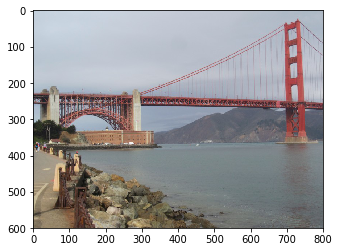

Is this pciture of the
Forth Bridge, Golden Gate Bridge, or Sydney Harbour Bridge?


In [17]:
from PIL import Image

def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions

    # based on code discussed in lectures
    
    # show image and print caption
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    print('Is this pciture of the')
    print('%s, %s, or %s?' % (predicted_landmarks[0], predicted_landmarks[1],predicted_landmarks[2]))

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

I am really impressed by the result!

Possible steps for improvement I can think of:
* More Training, maybe even with different optimizer
* Using a even more complex Network like ResNet
* Using more Images for training
* Resizing and only using fractions of the original images

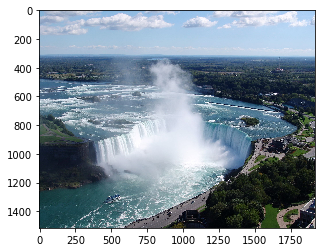

Is this pciture of the
Niagara Falls, Gullfoss Falls, or Yellowstone National Park?


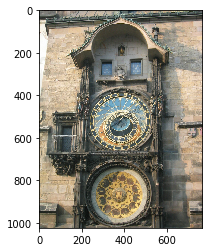

Is this pciture of the
Prague Astronomical Clock, Kantanagar Temple, or Gateway of India?


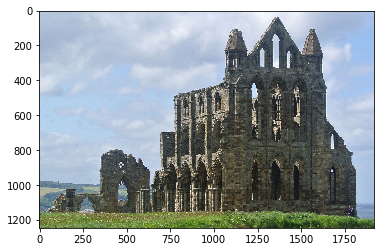

Is this pciture of the
Whitby Abbey, Edinburgh Castle, or Vienna City Hall?


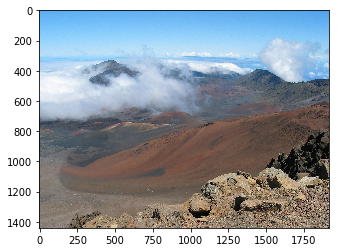

Is this pciture of the
Matterhorn, Gullfoss Falls, or Death Valley National Park?


In [18]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

# copied some pictures from wikipedia

import os

for filename in os.listdir('samples'):
    suggest_locations(os.path.join("samples", filename))